# RNNs

In this notebook you will learn how to build Recurrent Neural Networks (RNNs) for time series forecasting and sequence classification.

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/tf2_course/blob/master/06_rnns.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## Imports

In [1]:
%matplotlib inline

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras
import time

2023-05-18 15:06:16.250150: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

python 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:21) 
[GCC 9.4.0]
matplotlib 3.5.3
numpy 1.21.6
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.9.0
keras.api._v2.keras 2.9.0


In [4]:
assert sys.version_info >= (3, 5) # Python ≥3.5 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

# Exercise 1 – Time series forecasting

## 1.1) Load the data

Let's start with a simple univariate time series: the daily temperatures in Melbourne from 1981 to 1990 ([source](https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990)).

In [5]:
dataset_path = keras.utils.get_file(
    "daily-minimum-temperatures-in-me.csv",
    "https://raw.githubusercontent.com/ageron/tf2_course/master/datasets/daily-minimum-temperatures-in-me.csv")
    
temps = pd.read_csv(dataset_path,
                    parse_dates=[0], index_col=0)

In [6]:
temps.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3650 entries, 1981-01-01 to 1990-12-31
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  3650 non-null   float64
dtypes: float64(1)
memory usage: 57.0 KB


In [6]:
temps.head()

,Temperature
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


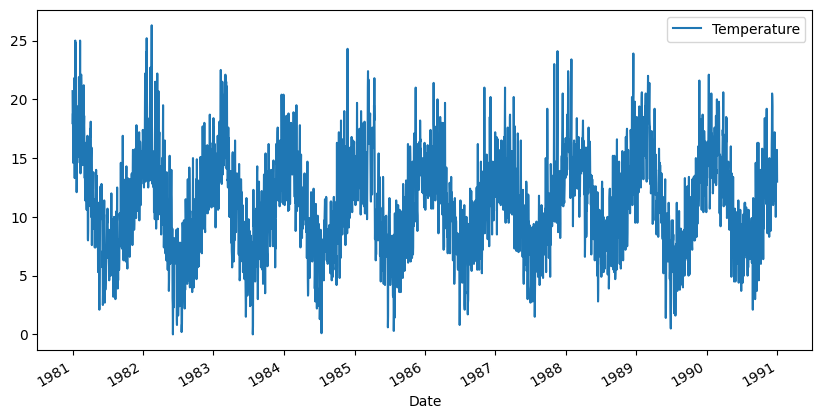

In [8]:
temps.plot(figsize=(10,5))
plt.show()

## 1.2) Prepare the data

A few dates are missing, for example December 31st, 1984:

In [7]:
temps.loc["1984-12-29":"1985-01-02"]

,Temperature
Date,
1984-12-29,16.0
1984-12-30,16.4
1985-01-01,13.3
1985-01-02,15.2


Let's ensure there's one row per day, filling missing values with the previous valid value:

In [8]:
temps = temps.asfreq("1D", method="ffill")
temps.loc["1984-12-29":"1985-01-02"]

,Temperature
Date,
1984-12-29,16.0
1984-12-30,16.4
1984-12-31,16.4
1985-01-01,13.3
1985-01-02,15.2


Alternatively, we could have interpolated using `temps.interpolate()`.

## 1.3) Add the shifted columns

Next, let's create a function to add lag columns:

In [9]:
def add_lags(series, times):
    cols = []
    column_index = []
    for time in times:
        cols.append(series.shift(-time))
        lag_fmt = "t+{time}" if time > 0 else "t{time}" if time < 0 else "t"
        column_index += [(lag_fmt.format(time=time), col_name)
                        for col_name in series.columns]
    df = pd.concat(cols, axis=1)
    df.columns = pd.MultiIndex.from_tuples(column_index)
    return df

We will try to predict the temperature in 5 days (t+5) using the temperatures from the last 30 days (t-29 to t):

In [12]:
X = add_lags(temps, times=range(-30+1,1)).iloc[30:-5]
y = add_lags(temps, times=[5]).iloc[30:-5]

In [13]:
X.head()

,t-29,t-28,t-27,t-26,t-25,t-24,t-23,t-22,t-21,t-20,...,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,...,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature
Date,,,,,,,,,,,,,,,,,,,,,
1981-01-31,17.9,18.8,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,...,12.1,14.4,16.0,16.5,18.7,19.4,17.2,15.5,15.1,15.4
1981-02-01,18.8,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,...,14.4,16.0,16.5,18.7,19.4,17.2,15.5,15.1,15.4,15.3
1981-02-02,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,...,16.0,16.5,18.7,19.4,17.2,15.5,15.1,15.4,15.3,18.8
1981-02-03,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,21.5,...,16.5,18.7,19.4,17.2,15.5,15.1,15.4,15.3,18.8,21.9
1981-02-04,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,21.5,25.0,...,18.7,19.4,17.2,15.5,15.1,15.4,15.3,18.8,21.9,19.9


In [14]:
y.head()

,t+5
,Temperature
Date,
1981-01-31,16.6
1981-02-01,16.8
1981-02-02,14.6
1981-02-03,17.1
1981-02-04,25.0


Note: you may want to use `keras.preprocessing.sequence.TimeseriesGenerator` or `tf.data.Dataset.window()` instead.

## 1.4) Split the dataset

Split this dataset into three periods: training (1981-1986), validation (1987-1988) and testing (1989-1990).

In [15]:
#X_train, y_train = ...
#X_valid, y_valid = ...
#X_test, y_test = ...

## 1.5) Reshape the inputs for the RNN

Keras and TensorFlow expect a 3D NumPy array for any sequence. Its shape should be (number of instances, number of time steps, number of features per time step). Since this is a univariate time series, the last dimension is 1. Reshape the input features to get 3D arrays:

In [16]:
#X_train_3D = ...
#X_valid_3D = ...
#X_test_3D = ...

## 1.6) Build some baseline models

Build some baseline models (at least one) and evaluate them on the validation set, using the Mean Absolute Error (MAE). For example:

* a naive model, that just predicts the last known value.
* an EMA model that predicts an exponential moving average of the last 48 hours (you can try to find the best span).
* a linear model.

Optional: plot the predictions.

## 1.7) Build a simple RNN

Using Keras, build a simple 2-layer RNN with 100 neurons per layer, plus a dense layer with a single neuron. Train the model for 200 epochs with a batch size of 200, using Stochastic Gradient Descent with an learning rate of 0.005. Make sure to print the validation loss during training.

Hints:

* Create a `Sequential` model.
* Add two `SimpleRNN` layers, with 100 units each. The first should return sequences but not the second. Indeed, in a Seq2Vec model, the last RNN layer should not return sequences. The first layer should specify the input shape (i.e., the shape of a single input sequence).
* Use the MSE as the loss.
* Call the model's `compile()` method, passing it an `SGD` instance with `lr=0.005`.
* Call the model's `fit()` method, with the inputs and targets, number of epochs, batch size and validation data.

In [17]:
#model1 = ...

## 1.8) Plot the history

Recall that you can simply use `pd.DataFrame(history.history).plot()`.

## 1.9) Evaluate the model

Evaluate your RNN on the validation set, using the MAE. Try training your model again using the Huber loss and see if you get better performance.

In [18]:
def huber_loss(y_true, y_pred, max_grad=1.):
    err = tf.abs(y_true - y_pred, name='abs')
    mg = tf.constant(max_grad, name='max_grad')
    lin = mg * (err - 0.5 * mg)
    quad = 0.5 * err * err
    return tf.where(err < mg, quad, lin)

## 1.10) Plot the predictions

Make predictions on the validation set and plot them. Compare them to the targets and the baseline predictions.

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

# Exercise 1 – Solution

## 1.1) Load the data

Let's start with a simple univariate time series: the daily temperatures in Melbourne from 1981 to 1990 ([source](https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990)).

In [19]:
dataset_path = keras.utils.get_file(
    "daily-minimum-temperatures-in-me.csv",
    "https://raw.githubusercontent.com/ageron/tf2_course/master/datasets/daily-minimum-temperatures-in-me.csv")
    
temps = pd.read_csv(dataset_path,
                    parse_dates=[0], index_col=0)

In [20]:
temps.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3650 entries, 1981-01-01 to 1990-12-31
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  3650 non-null   float64
dtypes: float64(1)
memory usage: 57.0 KB


In [21]:
temps.head()

,Temperature
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


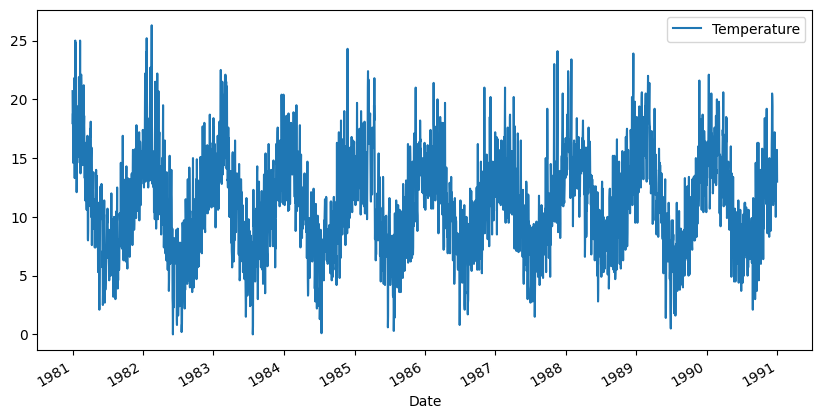

In [22]:
temps.plot(figsize=(10,5))
plt.show()

## 1.2) Prepare the data

A few dates are missing, for example December 31st, 1984:

In [23]:
temps.loc["1984-12-29":"1985-01-02"]

,Temperature
Date,
1984-12-29,16.0
1984-12-30,16.4
1985-01-01,13.3
1985-01-02,15.2


Let's ensure there's one row per day, filling missing values with the previous valid value:

In [24]:
temps = temps.asfreq("1D", method="ffill")
temps.loc["1984-12-29":"1985-01-02"]

,Temperature
Date,
1984-12-29,16.0
1984-12-30,16.4
1984-12-31,16.4
1985-01-01,13.3
1985-01-02,15.2


Alternatively, we could have interpolated using `temps.interpolate()`.

## 1.3) Add the shifted columns

Next, let's create a function to add lag columns:

In [25]:
def add_lags(series, times):
    cols = []
    column_index = []
    for time in times:
        cols.append(series.shift(-time))
        lag_fmt = "t+{time}" if time > 0 else "t{time}" if time < 0 else "t"
        column_index += [(lag_fmt.format(time=time), col_name)
                        for col_name in series.columns]
    df = pd.concat(cols, axis=1)
    df.columns = pd.MultiIndex.from_tuples(column_index)
    return df

In [26]:
add_lags(temps, times=(-2, -1, 0, +2)).head(10)

,t-2,t-1,t,t+2
,Temperature,Temperature,Temperature,Temperature
Date,,,,
1981-01-01,NaN,NaN,20.7,18.8
1981-01-02,NaN,20.7,17.9,14.6
1981-01-03,20.7,17.9,18.8,15.8
1981-01-04,17.9,18.8,14.6,15.8
1981-01-05,18.8,14.6,15.8,15.8
1981-01-06,14.6,15.8,15.8,17.4
1981-01-07,15.8,15.8,15.8,21.8
1981-01-08,15.8,15.8,17.4,20.0


We will try to predict the temperature in 5 days (t+5) using the temperatures from the last 30 days (t-29 to t):

In [27]:
X = add_lags(temps, times=range(-30+1,1)).iloc[30:-5]
y = add_lags(temps, times=[5]).iloc[30:-5]

In [28]:
X.head()

,t-29,t-28,t-27,t-26,t-25,t-24,t-23,t-22,t-21,t-20,...,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,...,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature
Date,,,,,,,,,,,,,,,,,,,,,
1981-01-31,17.9,18.8,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,...,12.1,14.4,16.0,16.5,18.7,19.4,17.2,15.5,15.1,15.4
1981-02-01,18.8,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,...,14.4,16.0,16.5,18.7,19.4,17.2,15.5,15.1,15.4,15.3
1981-02-02,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,...,16.0,16.5,18.7,19.4,17.2,15.5,15.1,15.4,15.3,18.8
1981-02-03,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,21.5,...,16.5,18.7,19.4,17.2,15.5,15.1,15.4,15.3,18.8,21.9
1981-02-04,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,21.5,25.0,...,18.7,19.4,17.2,15.5,15.1,15.4,15.3,18.8,21.9,19.9


In [29]:
y.head()

,t+5
,Temperature
Date,
1981-01-31,16.6
1981-02-01,16.8
1981-02-02,14.6
1981-02-03,17.1
1981-02-04,25.0


## 1.4) Split the dataset

Let's split this dataset into three periods: training, validation and testing:

In [30]:
train_slice = slice(None, "1986-12-25")
valid_slice = slice("1987-01-01", "1988-12-25")
test_slice = slice("1989-01-01", None)

In [31]:
X_train, y_train = X.loc[train_slice], y.loc[train_slice]
X_valid, y_valid = X.loc[valid_slice], y.loc[valid_slice]
X_test, y_test = X.loc[test_slice], y.loc[test_slice]

## 1.5) Reshape the inputs for the RNN

Now let's create a function to reshape the multilevel DataFrames to 3D numpy arrays to feed to an RNN:

In [32]:
def multilevel_df_to_ndarray(df):
    shape = [-1] + [len(level) for level in df.columns.remove_unused_levels().levels]
    return df.values.reshape(shape)

In [33]:
X_train_3D = multilevel_df_to_ndarray(X_train)
X_valid_3D = multilevel_df_to_ndarray(X_valid)
X_test_3D = multilevel_df_to_ndarray(X_test)

In [34]:
X_train.shape

(2155, 30)

In [35]:
X_train_3D.shape

(2155, 30, 1)

## 1.6) Build some baseline models

Now let's evaluate some basic strategies, to get some baselines:

In [36]:
from sklearn.metrics import mean_absolute_error

In [37]:
def naive(X):
    return X.iloc[:, -1]

In [38]:
y_pred_naive = naive(X_valid)

In [39]:
mean_absolute_error(y_valid, y_pred_naive)

2.976551724137931

In [40]:
def ema(X, span):
    return X.T.ewm(span=span).mean().T.iloc[:, -1]

In [41]:
y_pred_ema = ema(X_valid, span=10)

In [42]:
mean_absolute_error(y_valid, y_pred_ema)

2.3581754113889133

In [43]:
from sklearn.linear_model import LinearRegression

In [44]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


LinearRegression()

In [45]:
y_pred_linear = lin_reg.predict(X_valid)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


In [46]:
mean_absolute_error(y_valid, y_pred_linear)

2.2606549856754157

Let's plot these predictions:

In [47]:
def plot_predictions(*named_predictions, start=None, end=None, **kwargs):
    day_range = slice(start, end)
    plt.figure(figsize=(10,5))
    for name, y_pred in named_predictions:
        if hasattr(y_pred, "values"):
            y_pred = y_pred.values
        plt.plot(y_pred[day_range], label=name, **kwargs)
    plt.legend()
    plt.show()

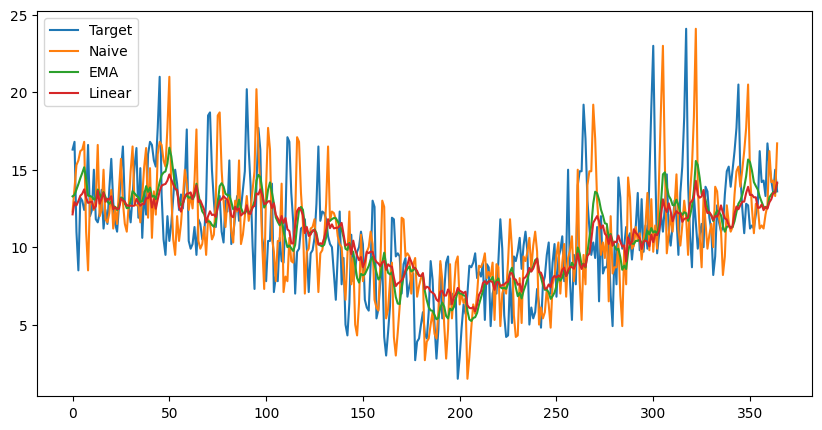

In [48]:
plot_predictions(("Target", y_valid),
                 ("Naive", y_pred_naive),
                 ("EMA", y_pred_ema),
                 ("Linear", y_pred_linear),
                 end=365)

## 1.7) Build a simple RNN

Let's create a simple 2-layer RNN with 100 neurons per layer, plus a dense layer with a single neuron:

In [49]:
input_shape = X_train_3D.shape[1:]
input_shape

(30, 1)

In [50]:
model1 = keras.models.Sequential()
model1.add(keras.layers.SimpleRNN(100, return_sequences=True, input_shape=input_shape))
model1.add(keras.layers.SimpleRNN(50))
model1.add(keras.layers.Dense(1))
model1.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=0.005), metrics=["mae"])

2023-05-14 03:59:39.558186: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-14 03:59:43.935729: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20661 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9
2023-05-14 03:59:43.939533: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 20661 MB memory:  -> device: 1, name: NVIDIA L4, pci bus id: 0000:00:04.0, compute capability: 8.9
2023-05-14 03:59:43.943420: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:G

In [51]:
history1 = model1.fit(X_train_3D, y_train, epochs=200, batch_size=200,
                      validation_data=(X_valid_3D, y_valid))

Epoch 1/200
 7/11 [==================>...........] - ETA: 0s - loss: 43.0607 - mae: 5.0474

2023-05-14 03:59:46.949364: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


11/11 [==============================] - 3s 71ms/step - loss: 33.4625 - mae: 4.3809 - val_loss: 12.4599 - val_mae: 2.7818
Epoch 2/200
11/11 [==============================] - 0s 39ms/step - loss: 13.7694 - mae: 2.9079 - val_loss: 10.2667 - val_mae: 2.5221
Epoch 3/200
11/11 [==============================] - 0s 39ms/step - loss: 13.3453 - mae: 2.8681 - val_loss: 9.9880 - val_mae: 2.4841
Epoch 4/200
11/11 [==============================] - 0s 39ms/step - loss: 12.7047 - mae: 2.8021 - val_loss: 12.2661 - val_mae: 2.7925
Epoch 5/200
11/11 [==============================] - 0s 39ms/step - loss: 11.1583 - mae: 2.6313 - val_loss: 10.2250 - val_mae: 2.5492
Epoch 6/200
11/11 [==============================] - 0s 39ms/step - loss: 12.4735 - mae: 2.7613 - val_loss: 9.8414 - val_mae: 2.4503
Epoch 7/200
11/11 [==============================] - 0s 39ms/step - loss: 10.9281 - mae: 2.5876 - val_loss: 10.0883 - val_mae: 2.5312
Epoch 8/200
11/11 [==============================] - 0s 40ms/step - loss: 10

## 1.8) Plot the history

In [52]:
def plot_history(history, loss="loss"):
    train_losses = history.history[loss]
    valid_losses = history.history["val_" + loss]
    n_epochs = len(history.epoch)
    minloss = np.min(valid_losses)
    
    plt.plot(train_losses, color="b", label="Train")
    plt.plot(valid_losses, color="r", label="Validation")
    plt.plot([0, n_epochs], [minloss, minloss], "k--",
             label="Min val: {:.2f}".format(minloss))
    plt.axis([0, n_epochs, 0, 20])
    plt.legend()
    plt.show()

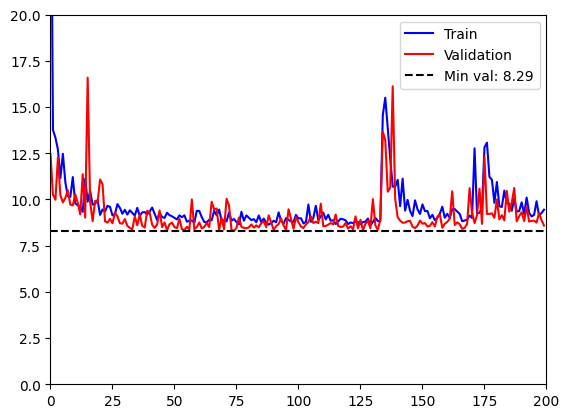

In [53]:
plot_history(history1)

## 1.9) Evaluate the model

In [54]:
model1.evaluate(X_valid_3D, y_valid)

23/23 [==============================] - 0s 6ms/step - loss: 8.5887 - mae: 2.3228


[8.588732719421387, 2.3228235244750977]

In [55]:
def huber_loss(y_true, y_pred, max_grad=1.):
    err = tf.abs(y_true - y_pred, name='abs')
    mg = tf.constant(max_grad, name='max_grad')
    lin = mg * (err - 0.5 * mg)
    quad = 0.5 * err * err
    return tf.where(err < mg, quad, lin)

In [56]:
model1 = keras.models.Sequential()
model1.add(keras.layers.SimpleRNN(100, return_sequences=True, input_shape=input_shape))
model1.add(keras.layers.SimpleRNN(100))
model1.add(keras.layers.Dense(1))
model1.compile(loss=huber_loss, optimizer=keras.optimizers.SGD(lr=0.005), metrics=["mae"])

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [57]:
history1 = model1.fit(X_train_3D, y_train, epochs=200, batch_size=200,
                      validation_data=(X_valid_3D, y_valid))

Epoch 1/200
11/11 [==============================] - 2s 73ms/step - loss: 5.8241 - mae: 6.3105 - val_loss: 3.1693 - val_mae: 3.6402
Epoch 2/200
11/11 [==============================] - 0s 40ms/step - loss: 2.8470 - mae: 3.3165 - val_loss: 2.4822 - val_mae: 2.9444
Epoch 3/200
11/11 [==============================] - 0s 40ms/step - loss: 2.6047 - mae: 3.0684 - val_loss: 2.3738 - val_mae: 2.8335
Epoch 4/200
11/11 [==============================] - 0s 39ms/step - loss: 2.5189 - mae: 2.9803 - val_loss: 2.2875 - val_mae: 2.7455
Epoch 5/200
11/11 [==============================] - 0s 40ms/step - loss: 2.4055 - mae: 2.8665 - val_loss: 2.1770 - val_mae: 2.6348
Epoch 6/200
11/11 [==============================] - 0s 39ms/step - loss: 2.2715 - mae: 2.7326 - val_loss: 2.0650 - val_mae: 2.5204
Epoch 7/200
11/11 [==============================] - 0s 41ms/step - loss: 2.1619 - mae: 2.6223 - val_loss: 1.9948 - val_mae: 2.4511
Epoch 8/200
11/11 [==============================] - 0s 39ms/step - loss: 2.

In [58]:
model1.evaluate(X_valid_3D, y_valid)

23/23 [==============================] - 0s 6ms/step - loss: 1.7663 - mae: 2.2215


[1.7662672996520996, 2.2214694023132324]

## 1.10) Plot the predictions

In [59]:
y_pred_rnn1 = model1.predict(X_valid_3D)

23/23 [==============================] - 0s 6ms/step


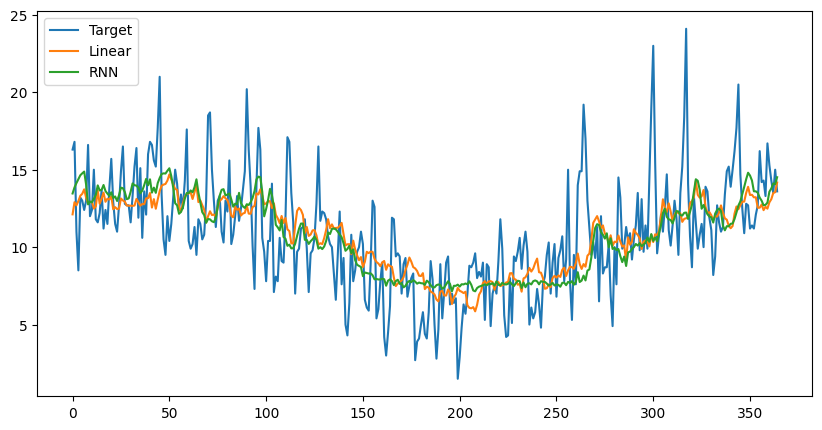

In [60]:
plot_predictions(("Target", y_valid),
                 ("Linear", y_pred_linear),
                 ("RNN", y_pred_rnn1),
                 end=365)

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

# Exercise 2 – Forecasting the shifted sequence (Seq2Seq)

Now let's predict temperatures for 30 days (from t-24 to t+5) instead of just one.

## 2.1) Define the 3D targets for training, validation and testing

In [61]:
#Y_train_3D = ...
#Y_valid_3D = ...
#Y_test_3D = ...

## 2.2) Define an `mae_last_step()` function

For the final evaluation, we only want to look at the final time step (t+5). Create an `mae_last_step()` function that computes the MAE based on the final time step.

## 2.3) Build a Seq2Seq model

Build a Seq2Seq model and compile it, using the Huber Loss, and using the last step MAE as the metric. Use SGD with a learning rate of 0.01. Hint: the layers are the same as earlier, except that the last RNN layer has `return_sequences=False`, and the `Dense` layer must be wrapped in a `keras.layers.TimeDistributed` layer.

## 2.4) Train the model

Fit the model as earlier (but with the 3D targets). Again, evaluate the model and plot the predictions.

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

# Exercise 2 – Solution

## 2.1) Define the 3D targets for training, validation and testing

In [62]:
Y = add_lags(temps, times=range(-24, 5+1)).iloc[30:-5]
Y_train = Y.loc[train_slice]
Y_valid = Y.loc[valid_slice]
Y_test = Y.loc[test_slice]
Y_train_3D = multilevel_df_to_ndarray(Y_train)
Y_valid_3D = multilevel_df_to_ndarray(Y_valid)
Y_test_3D = multilevel_df_to_ndarray(Y_test)

## 2.2) Define an `mae_last_step()` function

For the final evaluation, we only want to look at the final time step (t+5):

In [63]:
K = keras.backend

def mae_last_step(Y_true, Y_pred):
    return K.mean(K.abs(Y_pred[:, -1] - Y_true[:, -1]))

## 2.3) Build a Seq2Seq model

In [64]:
model2 = keras.models.Sequential()
model2.add(keras.layers.SimpleRNN(100, return_sequences=True, input_shape=input_shape))
model2.add(keras.layers.SimpleRNN(100, return_sequences=True))
model2.add(keras.layers.TimeDistributed(keras.layers.Dense(1)))
model2.compile(loss=huber_loss, optimizer=keras.optimizers.SGD(lr=0.01),
               metrics=[mae_last_step])

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


## 2.4) Train the model

In [65]:
history2 = model2.fit(X_train_3D, Y_train_3D, epochs=200, batch_size=200,
                      validation_data=(X_valid_3D, Y_valid_3D))

Epoch 1/200
11/11 [==============================] - 2s 71ms/step - loss: 5.5874 - mae_last_step: 5.8778 - val_loss: 2.8571 - val_mae_last_step: 3.2786
Epoch 2/200
11/11 [==============================] - 0s 40ms/step - loss: 2.8064 - mae_last_step: 3.1638 - val_loss: 2.4447 - val_mae_last_step: 2.8745
Epoch 3/200
11/11 [==============================] - 0s 38ms/step - loss: 2.6398 - mae_last_step: 3.0228 - val_loss: 2.3132 - val_mae_last_step: 2.7514
Epoch 4/200
11/11 [==============================] - 0s 38ms/step - loss: 2.4335 - mae_last_step: 2.8155 - val_loss: 2.1074 - val_mae_last_step: 2.5437
Epoch 5/200
11/11 [==============================] - 0s 38ms/step - loss: 2.2446 - mae_last_step: 2.6150 - val_loss: 2.0330 - val_mae_last_step: 2.4807
Epoch 6/200
11/11 [==============================] - 0s 41ms/step - loss: 2.1525 - mae_last_step: 2.5286 - val_loss: 1.9905 - val_mae_last_step: 2.4051
Epoch 7/200
11/11 [==============================] - 0s 41ms/step - loss: 2.2010 - mae_l

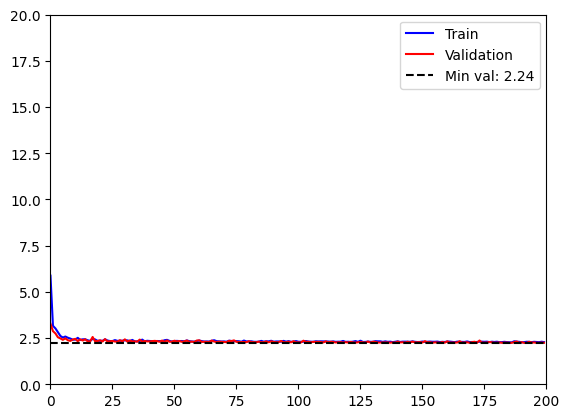

In [66]:
plot_history(history2, loss="mae_last_step")

In [67]:
model2.evaluate(X_valid_3D, Y_valid_3D)

23/23 [==============================] - 0s 6ms/step - loss: 1.8070 - mae_last_step: 2.2328


[1.8069669008255005, 2.232759714126587]

In [68]:
y_pred_rnn2 = model2.predict(X_valid_3D)[:, -1]

23/23 [==============================] - 0s 6ms/step


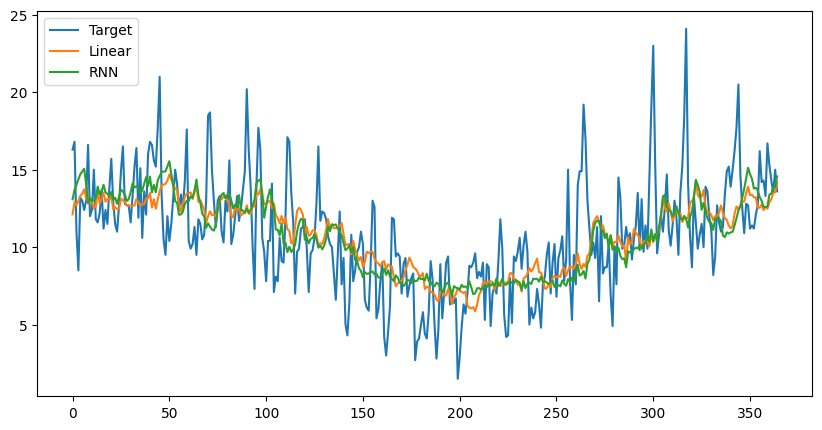

In [69]:
plot_predictions(("Target", y_valid),
                 ("Linear", y_pred_linear),
                 ("RNN", y_pred_rnn2),
                 end=365)

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

# Exercise 3 – LSTM and GRU

## 3.1) Build, train and evaluate a Seq2Seq LSTM

Train the same model as earlier but using `LSTM` or `GRU` instead of `SimpleRNN`. You can also try reducing the learning rate when the validation loss reaches a plateau, using the `ReduceLROnPlateau` callback.

## 3.2) Add $\ell_2$ regularization

Add $\ell_2$ regularization to your RNN, using the layers' `kernel_regularizer` and `recurrent_regularizer` arguments, and the `l2()` function in `keras.regularizers`. Tip: use the `partial()` function in the `functools` package to avoid repeating the same arguments again and again.

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

# Exercise 3 – Solution

## 3.1) Build, train and evaluate a Seq2Seq LSTM

You can try replacing `LSTM` with `GRU`.

In [70]:
model3 = keras.models.Sequential()
model3.add(keras.layers.LSTM(100, return_sequences=True, input_shape=input_shape))
model3.add(keras.layers.LSTM(100, return_sequences=True))
model3.add(keras.layers.TimeDistributed(keras.layers.Dense(1)))
model3.compile(loss=huber_loss, optimizer=keras.optimizers.SGD(lr=0.01),
               metrics=[mae_last_step])

In [71]:
history3 = model3.fit(X_train_3D, Y_train_3D, epochs=200, batch_size=200,
                      validation_data=(X_valid_3D, Y_valid_3D),
                      callbacks=[keras.callbacks.ReduceLROnPlateau(verbose=1)])

Epoch 1/200


2023-05-14 04:04:32.782160: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


11/11 [==============================] - 5s 94ms/step - loss: 8.7363 - mae_last_step: 8.8669 - val_loss: 7.2636 - val_mae_last_step: 7.2808 - lr: 0.0100
Epoch 2/200
11/11 [==============================] - 0s 16ms/step - loss: 5.8372 - mae_last_step: 5.6288 - val_loss: 4.7602 - val_mae_last_step: 4.5866 - lr: 0.0100
Epoch 3/200
11/11 [==============================] - 0s 16ms/step - loss: 4.0146 - mae_last_step: 3.8083 - val_loss: 3.4021 - val_mae_last_step: 3.2352 - lr: 0.0100
Epoch 4/200
11/11 [==============================] - 0s 16ms/step - loss: 3.2964 - mae_last_step: 3.1795 - val_loss: 2.9755 - val_mae_last_step: 2.9030 - lr: 0.0100
Epoch 5/200
11/11 [==============================] - 0s 16ms/step - loss: 3.1137 - mae_last_step: 3.1030 - val_loss: 2.8531 - val_mae_last_step: 2.8352 - lr: 0.0100
Epoch 6/200
11/11 [==============================] - 0s 16ms/step - loss: 3.0430 - mae_last_step: 3.0721 - val_loss: 2.7877 - val_mae_last_step: 2.7959 - lr: 0.0100
Epoch 7/200
11/11 [===

In [72]:
model3.evaluate(X_valid_3D, Y_valid_3D)

23/23 [==============================] - 0s 3ms/step - loss: 1.8590 - mae_last_step: 2.2455


[1.8589835166931152, 2.245495080947876]

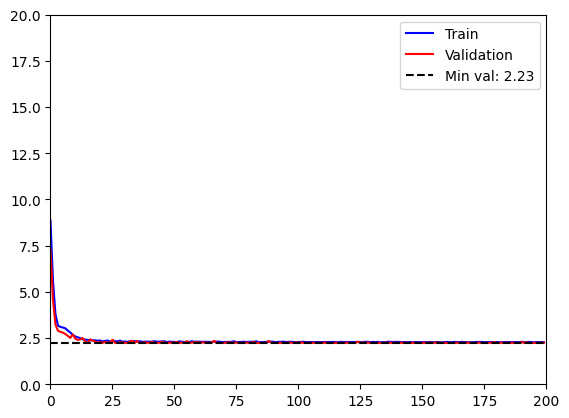

In [73]:
plot_history(history3, loss="mae_last_step")

In [74]:
y_pred_rnn3 = model3.predict(X_valid_3D)[:, -1]

23/23 [==============================] - 1s 2ms/step


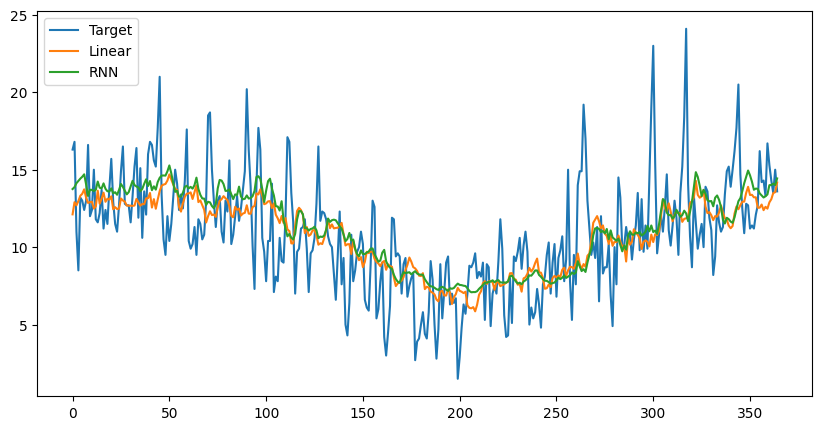

In [75]:
plot_predictions(("Target", y_valid),
                 ("Linear", y_pred_linear),
                 ("RNN", y_pred_rnn3),
                 end=365)

## 3.2) Add $\ell_2$ regularization

In [76]:
from functools import partial

In [77]:
RegularizedLSTM = partial(keras.layers.LSTM,
                          return_sequences=True,
                          kernel_regularizer=keras.regularizers.l2(1e-4),
                          recurrent_regularizer=keras.regularizers.l2(1e-4))

In [78]:
model3 = keras.models.Sequential()
model3.add(RegularizedLSTM(100, input_shape=input_shape))
model3.add(RegularizedLSTM(100))
model3.add(keras.layers.Dense(1))
model3.compile(loss=huber_loss, optimizer=keras.optimizers.SGD(lr=0.01),
               metrics=[mae_last_step])

In [79]:
history3 = model3.fit(X_train_3D, Y_train_3D, epochs=200, batch_size=100,
                      validation_data=(X_valid_3D, Y_valid_3D))

Epoch 1/200
22/22 [==============================] - 4s 51ms/step - loss: 7.9304 - mae_last_step: 7.8807 - val_loss: 5.5674 - val_mae_last_step: 5.7161
Epoch 2/200
22/22 [==============================] - 0s 12ms/step - loss: 4.0572 - mae_last_step: 3.8297 - val_loss: 3.0951 - val_mae_last_step: 3.1528
Epoch 3/200
22/22 [==============================] - 0s 12ms/step - loss: 3.1540 - mae_last_step: 3.1310 - val_loss: 2.8713 - val_mae_last_step: 2.9814
Epoch 4/200
22/22 [==============================] - 0s 11ms/step - loss: 3.0695 - mae_last_step: 3.1014 - val_loss: 2.8008 - val_mae_last_step: 2.9295
Epoch 5/200
22/22 [==============================] - 0s 12ms/step - loss: 2.9732 - mae_last_step: 3.0007 - val_loss: 2.6957 - val_mae_last_step: 2.8148
Epoch 6/200
22/22 [==============================] - 0s 11ms/step - loss: 2.8421 - mae_last_step: 2.8543 - val_loss: 2.6045 - val_mae_last_step: 2.7186
Epoch 7/200
22/22 [==============================] - 0s 12ms/step - loss: 2.6824 - mae_l

In [80]:
model3.evaluate(X_valid_3D, Y_valid_3D)

23/23 [==============================] - 0s 3ms/step - loss: 1.8534 - mae_last_step: 2.2115


[1.8534057140350342, 2.211491346359253]

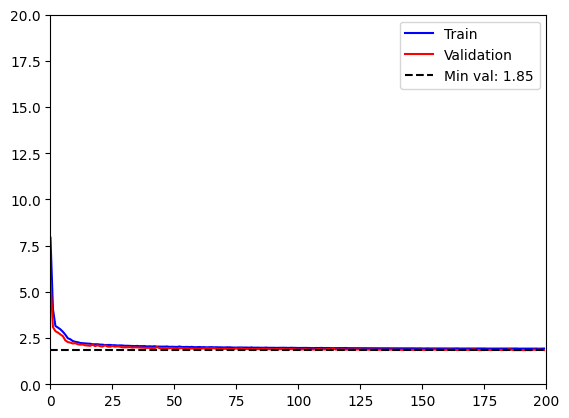

In [81]:
plot_history(history3)

In [82]:
y_pred_rnn3 = model3.predict(X_valid_3D)[:, -1]

23/23 [==============================] - 1s 3ms/step


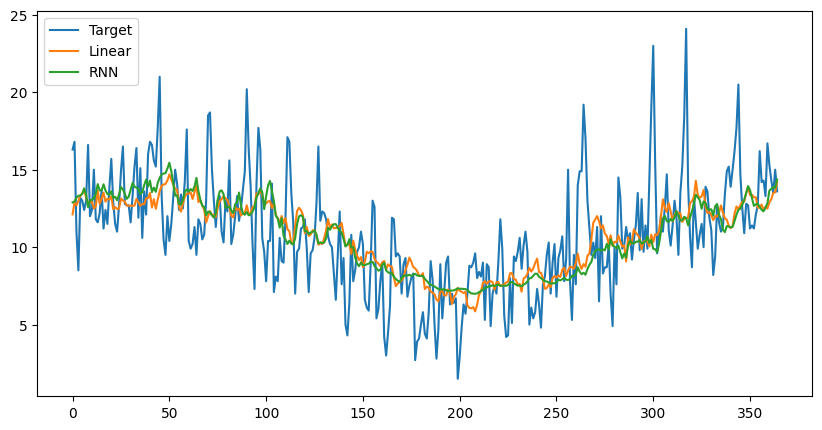

In [83]:
plot_predictions(("Target", y_valid),
                 ("Linear", y_pred_linear),
                 ("RNN", y_pred_rnn3),
                 end=365)

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

# Exercise 4 – Preprocessing with 1D-ConvNets

At the beginning of your sequential model, add a `Conv1D` layer with 32 kernels of size 5, a `MaxPool1D` layer with pool size 5 and strides 2. Train and evaluate the model.

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

# Exercise 4 – Solution

In [84]:
model4 = keras.models.Sequential()
model4.add(keras.layers.Conv1D(32, kernel_size=5, input_shape=input_shape))
model4.add(keras.layers.MaxPool1D(pool_size=5, strides=2))
model4.add(keras.layers.LSTM(32, return_sequences=True))
model4.add(keras.layers.LSTM(32))
model4.add(keras.layers.Dense(1))
model4.compile(loss=huber_loss, optimizer=keras.optimizers.SGD(lr=0.005))

In [85]:
model4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 26, 32)            192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 11, 32)           0         
 )                                                               
                                                                 
 lstm_4 (LSTM)               (None, 11, 32)            8320      
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 16,865
Trainable params: 16,865
Non-trainable params: 0
__________________________________________________

In [86]:
history4 = model4.fit(X_train_3D, y_train, epochs=200, batch_size=100,
                      validation_data=(X_valid_3D, y_valid))

Epoch 1/200


2023-05-14 04:06:15.941222: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-05-14 04:06:15.941258: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2023-05-14 04:06:15.941328: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


22/22 [==============================] - 6s 47ms/step - loss: 9.0807 - val_loss: 8.4886
Epoch 2/200
22/22 [==============================] - 0s 10ms/step - loss: 7.3989 - val_loss: 7.1097
Epoch 3/200
22/22 [==============================] - 0s 10ms/step - loss: 6.1302 - val_loss: 5.8051
Epoch 4/200
22/22 [==============================] - 0s 10ms/step - loss: 4.9438 - val_loss: 4.6081
Epoch 5/200
22/22 [==============================] - 0s 10ms/step - loss: 3.9679 - val_loss: 3.6791
Epoch 6/200
22/22 [==============================] - 0s 10ms/step - loss: 3.3362 - val_loss: 3.0963
Epoch 7/200
22/22 [==============================] - 0s 10ms/step - loss: 3.0000 - val_loss: 2.7910
Epoch 8/200
22/22 [==============================] - 0s 10ms/step - loss: 2.8362 - val_loss: 2.7121
Epoch 9/200
22/22 [==============================] - 0s 10ms/step - loss: 2.7486 - val_loss: 2.5297
Epoch 10/200
22/22 [==============================] - 0s 10ms/step - loss: 2.6405 - val_loss: 2.6069
Epoch 11/20

In [87]:
model4.evaluate(X_valid_3D, y_valid)

23/23 [==============================] - 0s 6ms/step - loss: 1.7929


1.792910099029541

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

# Exercice 5 – Sequence classification

Let's load the IMDB movie reviews, for binary sentiment analysis (positive review or negative review):

We only want the 10,000 most common words:

In [88]:
num_words = 10000
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)

Let's also get the word index (word to word id):

In [89]:
word_index = keras.datasets.imdb.get_word_index()

And let's create a reverse index (word id to word). Three special word ids are added:

In [90]:
reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

Let's write a little function to decode reviews:

In [91]:
def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

Let's look at a review:

In [92]:
decode_review(X_train[0])

"<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <oov> is an amazing actor and now the same being director <oov> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <oov> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <oov> to the two little boy's that played the <oov> of norman and paul they were just brilliant children are often left out of the <oov> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what

It seems very positive, let's look at the target (0=negative review, 1=positive review):

In [93]:
y_train[0]

1

And another review:

In [94]:
decode_review(X_train[1])

"<sos> big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal <oov> the hair is big lots of boobs <oov> men wear those cut <oov> shirts that show off their <oov> sickening that men actually wore them and the music is just <oov> trash that plays over and over again in almost every scene there is trashy music boobs and <oov> taking away bodies and the gym still doesn't close for <oov> all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then"

Very negative! Let's check the target:

In [95]:
y_train[1]

0

## 5.1) Train a baseline model

Train and evaluate a baseline model using ScikitLearn. You will need to create a pipeline with a `CountVectorizer`, a `TfidfTransformer` and an `SGDClassifier`. The `CountVectorizer` transformer expects text as input, so let's create a text version of the training set and test set:

In [96]:
X_train_text = [decode_review(words_ids) for words_ids in X_train]
X_test_text = [decode_review(words_ids) for words_ids in X_test]

In [97]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

## 5.2) Create a sequence classifier

Create a sequence classifier using Keras:
* Use `keras.preprocessing.sequence.pad_sequences()` to preprocess `X_train`: this will create a 2D array of 25,000 rows (one per review) and `maxlen=500` columns. Reviews longer than 500 words will be cropped, while reviews shorter 
than 500 words will be padded with zeros.
* The first layer in your model should be an `Embedding` layer, with `input_dim=num_words` and `output_dim=10`. The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector. So the next layer will receive 3D batchs of shape (batch size, 500, 10).
* Add one or more LSTM layers with 32 neurons each.
* The output layer should be a Dense layer with a sigmoid activation function, since this is a binary classification problem.
* When compiling the model, you should use the `binary_crossentropy` loss.
* Fit the model for 10 epochs, using a batch size of 128 and `validation_split=0.2`.

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

# Exercice 5 – Solution

## 5.1) Train a baseline model

In [98]:
X_train_text = [decode_review(words_ids) for words_ids in X_train]
X_test_text = [decode_review(words_ids) for words_ids in X_test]

In [99]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

In [100]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(max_iter=50)),
])

In [101]:
pipeline.fit(X_train_text, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(max_iter=50))])

In [102]:
pipeline.score(X_test_text, y_test)

0.88452

We get 88.5% accuracy, that's not too bad. But don't forget to check the ratio of positive reviews:

In [103]:
y_test.mean()

0.5

Let's try our model:

In [104]:
pipeline.predict(["this movie was really awesome"])

array([1])

## 5.2) Create a sequence classifier

In [105]:
maxlen = 500
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)

In [106]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.LSTM(32))
model.add(keras.layers.Dense(1, activation="sigmoid"))

In [107]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [108]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 10)          100000    
                                                                 
 lstm_6 (LSTM)               (None, 32)                5504      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 105,537
Trainable params: 105,537
Non-trainable params: 0
_________________________________________________________________


In [109]:
history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 5s 19ms/step - loss: 0.5692 - accuracy: 0.7194 - val_loss: 0.4777 - val_accuracy: 0.8372
Epoch 2/10
157/157 [==============================] - 2s 16ms/step - loss: 0.3646 - accuracy: 0.8569 - val_loss: 0.3391 - val_accuracy: 0.8670
Epoch 3/10
157/157 [==============================] - 2s 16ms/step - loss: 0.2791 - accuracy: 0.8912 - val_loss: 0.3217 - val_accuracy: 0.8602
Epoch 4/10
157/157 [==============================] - 2s 16ms/step - loss: 0.2411 - accuracy: 0.9107 - val_loss: 0.2951 - val_accuracy: 0.8736
Epoch 5/10
157/157 [==============================] - 2s 16ms/step - loss: 0.2027 - accuracy: 0.9259 - val_loss: 0.2924 - val_accuracy: 0.8748
Epoch 6/10
157/157 [==============================] - 3s 16ms/step - loss: 0.1807 - accuracy: 0.9333 - val_loss: 0.3233 - val_accuracy: 0.8560
Epoch 7/10
157/157 [==============================] - 2s 16ms/step - loss: 0.1589 - accuracy: 0.9425 - val_loss: 0.3499 - val_accuracy: 0.8446

In [110]:
model.evaluate(X_test_trim, y_test)

782/782 [==============================] - 5s 7ms/step - loss: 0.3727 - accuracy: 0.8686


[0.3727433979511261, 0.8686400055885315]

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

# Exercise 6 – Bidirectional RNN

Update the previous sequence classification model to use a bidirectional LSTM. For this, you just need to wrap the LSTM layer in a `Bidirectional` layer. If the model overfits, try adding a dropout layer.

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

# Exercise 6 – Solution

In [111]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model.add(keras.layers.Dense(1, activation="sigmoid"))

In [112]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [113]:
history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 9s 33ms/step - loss: 0.6525 - accuracy: 0.6284 - val_loss: 0.5383 - val_accuracy: 0.7638
Epoch 2/10
157/157 [==============================] - 4s 28ms/step - loss: 0.4462 - accuracy: 0.8066 - val_loss: 0.3654 - val_accuracy: 0.8500
Epoch 3/10
157/157 [==============================] - 4s 28ms/step - loss: 0.3495 - accuracy: 0.8569 - val_loss: 0.4362 - val_accuracy: 0.7860
Epoch 4/10
157/157 [==============================] - 4s 28ms/step - loss: 0.2998 - accuracy: 0.8809 - val_loss: 0.3356 - val_accuracy: 0.8610
Epoch 5/10
157/157 [==============================] - 4s 28ms/step - loss: 0.2668 - accuracy: 0.8949 - val_loss: 0.2985 - val_accuracy: 0.8862
Epoch 6/10
157/157 [==============================] - 4s 28ms/step - loss: 0.2409 - accuracy: 0.9067 - val_loss: 0.2708 - val_accuracy: 0.8854
Epoch 7/10
157/157 [==============================] - 4s 28ms/step - loss: 0.2262 - accuracy: 0.9144 - val_loss: 0.3244 - val_accuracy: 0.8584

In [114]:
model.evaluate(X_test_trim, y_test)

782/782 [==============================] - 9s 11ms/step - loss: 0.3129 - accuracy: 0.8805


[0.31289541721343994, 0.8805199861526489]

In [118]:
batch_size = 64
# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
input_dim = 28

units = 64
output_size = 10  # labels are from 0 to 9

# Build the RNN model
def build_model(allow_cudnn_kernel=True):
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.
        lstm_layer = keras.layers.LSTM(units, input_shape=(None, input_dim))
    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = keras.layers.RNN(
            keras.layers.LSTMCell(units), input_shape=(None, input_dim)
        )
    model = keras.models.Sequential(
        [
            lstm_layer,
            keras.layers.BatchNormalization(),
            keras.layers.Dense(output_size),
        ]
    )

    return model

In [119]:
mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
sample, sample_label = x_train[0], y_train[0]

In [122]:
model = build_model(allow_cudnn_kernel=True)

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)


model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

938/938 [==============================] - 8s 7ms/step - loss: 0.9712 - accuracy: 0.6932 - val_loss: 0.5311 - val_accuracy: 0.8299


In [121]:
noncudnn_model = build_model(allow_cudnn_kernel=False)
noncudnn_model.set_weights(model.get_weights())
noncudnn_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)
noncudnn_model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

938/938 [==============================] - 29s 30ms/step - loss: 0.4186 - accuracy: 0.8725 - val_loss: 0.3475 - val_accuracy: 0.8874
